# 02__mpranalyze_quantify

in this notebook, i run the R package MPRAnalyze on the set of TSSs in order to quantify TSS activities. i first have MPRAnalyze estimate the library depth correction factors based on the full set of elements (though HUES64 is downsampled). then i have it run in quantify mode, using the RANDOM sequences as negative controls.

In [1]:
# # install MPRAnalyze
# if (!requireNamespace("BiocManager", quietly = TRUE))
#   install.packages("BiocManager")
# BiocManager::install("MPRAnalyze", version = "3.8")

In [2]:
# # install RCurl -- not installing separately was causing errors
# install.packages("RCurl")

In [3]:
# # install biocparallel
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("BiocParallel")

In [4]:
# load the mpranalyze package
library(MPRAnalyze)

In [5]:
library(BiocParallel)

In [6]:
options(MulticoreParam=quote(MulticoreParam(workers=8)))

In [7]:
par.backend <- bpparam()

In [8]:
par.backend

MulticoreParam(workers = 8)

## 1. load data

### first the data for library depth correction

In [9]:
dna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)

# since we only have 1 dna replicate -- add another so code doesn't crash (expects matrix)
dna_counts_depth["dna_2"] <- dna_counts_depth["dna_1"]

row.names(dna_counts_depth) <- dna_counts_depth$element
dna_counts_depth <- dna_counts_depth[ , !(names(dna_counts_depth) %in% c("element")), drop=FALSE]
dna_counts_depth <- as.matrix(dna_counts_depth)

In [10]:
rna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
row.names(rna_counts_depth) <- rna_counts_depth$element
rna_counts_depth <- rna_counts_depth[ , !(names(rna_counts_depth) %in% c("element")), drop=FALSE]
rna_counts_depth <- as.matrix(rna_counts_depth)

In [11]:
dna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(dna_cols_depth) <- c("id", "condition", "sample")

# add second row to dna_cols_depth
row2 <- data.frame(id="dna_2", condition="dna", sample="2")
dna_cols_depth <- rbind(dna_cols_depth, row2)
row.names(dna_cols_depth) <- dna_cols_depth$id

rna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(rna_cols_depth) <- c("id", "condition", "sample")
row.names(rna_cols_depth) <- rna_cols_depth$id
dna_cols_depth

,id,condition,sample
,<fct>,<fct>,<chr>
dna_1,dna_1,dna,1
dna_2,dna_2,dna,2


In [12]:
rna_cols_depth

,id,condition,sample
,<fct>,<fct>,<int>
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
HUES64_rep3,HUES64_rep3,HUES64,3
mESC_rep1,mESC_rep1,mESC,1
mESC_rep2,mESC_rep2,mESC,2
mESC_rep3,mESC_rep3,mESC,3


In [13]:
# make sure everything is a factor
dna_cols_depth$condition <- as.factor(dna_cols_depth$condition)
rna_cols_depth$condition <- as.factor(rna_cols_depth$condition)
rna_cols_depth$sample <- as.factor(rna_cols_depth$sample)

In [14]:
rna_cols_depth

,id,condition,sample
,<fct>,<fct>,<fct>
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
HUES64_rep3,HUES64_rep3,HUES64,3
mESC_rep1,mESC_rep1,mESC,1
mESC_rep2,mESC_rep2,mESC,2
mESC_rep3,mESC_rep3,mESC,3


### then the data to model

In [15]:
dna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.mpranalyze.for_quantification.txt", sep="\t", header=TRUE)
row.names(dna_counts) <- dna_counts$element
dna_counts <- dna_counts[ , !(names(dna_counts) %in% c("element"))]
dna_counts <- as.matrix(dna_counts)

In [16]:
rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_counts.mpranalyze.for_quantification.txt", sep="\t", header=TRUE)
row.names(rna_counts) <- rna_counts$element
rna_counts <- rna_counts[ , !(names(rna_counts) %in% c("element"))]
rna_counts <- as.matrix(rna_counts)

In [17]:
dna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.mpranalyze.for_quantification.txt", sep="\t", header=TRUE)
row.names(dna_cols) <- dna_cols$X
rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_col_ann.mpranalyze.for_quantification.txt", sep="\t", header=TRUE)
row.names(rna_cols) <- rna_cols$X

In [18]:
# make sure everything is a factor
dna_cols$barcode <- as.factor(dna_cols$barcode)
rna_cols$barcode <- as.factor(rna_cols$barcode)
dna_cols$sample <- as.factor(dna_cols$sample)
dna_cols$condition <- as.factor(dna_cols$condition)
rna_cols$condition <- as.factor(rna_cols$condition)

In [19]:
ctrls <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/ctrl_status.mpranalyze.for_quantification.txt", sep="\t", header=TRUE)
ctrls <- as.logical(ctrls$ctrl_status)

In [20]:
head(rna_cols)

,X,sample,condition,barcode
,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:1,samp:HUES64_rep1__barc:1,rep1,HUES64,1
samp:HUES64_rep1__barc:10,samp:HUES64_rep1__barc:10,rep1,HUES64,10
samp:HUES64_rep1__barc:11,samp:HUES64_rep1__barc:11,rep1,HUES64,11
samp:HUES64_rep1__barc:12,samp:HUES64_rep1__barc:12,rep1,HUES64,12
samp:HUES64_rep1__barc:13,samp:HUES64_rep1__barc:13,rep1,HUES64,13
samp:HUES64_rep1__barc:2,samp:HUES64_rep1__barc:2,rep1,HUES64,2


## 2. estimate library depth for sample/condition pair

since our library has many more sequences than just the TSSs we want to model, estimate the library depth based on the full seq output (or downsampled counts, in HUES64 case), then manually provide this estimation to the model

In [21]:
# create MPRA object
depth_obj <- MpraObject(dnaCounts = dna_counts_depth, rnaCounts = rna_counts_depth, 
                        dnaAnnot = dna_cols_depth, rnaAnnot = rna_cols_depth)

In [22]:
# estimate depth factors using uq -- here, a sample/condition pair == 1 library
depth_obj <- estimateDepthFactors(depth_obj, lib.factor = c("sample", "condition"),  depth.estimator='uq',
                                  which.lib = "dna")
depth_obj <- estimateDepthFactors(depth_obj, lib.factor = c("id"),  
                                  depth.estimator='uq', which.lib = "rna")

In [23]:
rna_depths <- rnaDepth(depth_obj)
rna_depths

[1] 1.0000000 0.6751932 0.7720110 0.3075865 0.3853071 0.3660570

In [24]:
rna_cols_depth

,id,condition,sample
,<fct>,<fct>,<fct>
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
HUES64_rep3,HUES64_rep3,HUES64,3
mESC_rep1,mESC_rep1,mESC,1
mESC_rep2,mESC_rep2,mESC,2
mESC_rep3,mESC_rep3,mESC,3


## 3. run MPRAnalyze quantification to get alpha per element
using the random sequences as negative controls (but positive controls are in here and will also be quantified)

In [25]:
# first need to set the dnadepths and rnadepths manually
dna_cols$depth <- rep(1, nrow(dna_cols))

In [26]:
# note 13 will change depending how many barcodes there are per element
rna_cols$depth <- rep(rna_depths, each=13)

In [27]:
# create MPRA object
obj <- MpraObject(dnaCounts = dna_counts, rnaCounts = rna_counts, 
                  dnaAnnot = dna_cols, rnaAnnot = rna_cols, 
                  controls = ctrls, BPPARAM = SnowParam(workers=16,type="SOCK"))

In [28]:
# set depth factors manually
obj <- setDepthFactors(obj, dnaDepth = dna_cols$depth, rnaDepth = rna_cols$depth)

In [29]:
# analyze quantification in unpaired DNA library
obj <- analyzeQuantification(obj = obj, 
                             dnaDesign = ~ barcode,
                             rnaDesign = ~ condition)

Fitting model...
Analysis done!


In [30]:
# extract alphas
alpha <- getAlpha(obj, by.factor = "condition")
head(alpha)

,HUES64,mESC
,<dbl>,<dbl>
AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCCGGAAGTCCCTCCGCGGTGACGAGCACGGCGGAAGTGGGTTCAATGCAGCTCCCCGAAGAACTGTCTCACTCCCGCTCGCCTGACTTCTGGATGGGAGG,7.2952385,6.3159106
AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAGGGGAAGTTTCAAAGGGTGTGCCGGGGACCGGGGAAGAGTCTCATTCTCATGAGTCAGCGGATCCGGCCCAGTGTGACTTCACTGCTTCCCCAGAAGAG,1.3267957,1.3488240
AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAAACTTTCAAATGTGCTAGGGTTCCTGGAATTTGGAGAGGGAACCGAAAGGGTTTTATGGTTCTTGGGAGACAGCAGAGCACAAAGAGCCAGGGGGTGGA,0.9771642,1.5489158
AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACTGGAAAATTCATCCCTGCAACCTTCCCTCCCATTTCACTGGTCAGAGTAAAAATTGGAAGTAGGAAAATTAGTACCACCACATCCTTTGAGTCAGAGAC,0.9761269,0.8181706
AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCAGATTCTGATGGGACGATGTCTCAGTAGCACCGCCAATGTGTGTGTAATTGACTGATCCAGTCAGTAGGGGGCCTGACTCCACAACGTTCAAGAGAATC,1.3239991,1.4571282
AAAAAAAAATGAGAAGTGTTTAAGACAGCGCAACATTACAATAGAATATTGCCTTGTTTTCTTTCTGGTTCTTCTGTCTCACAGAAATTTCTGTAAGTTCACTCCCTCAGAGGGGAAAAGGCAAGGACACAAGCAAGAGAATGA,1.1364331,1.0491923


In [31]:
head(alpha[ctrls,])

,HUES64,mESC
,<dbl>,<dbl>
AAAACAGAAGGCTGATCAGTCACATTACATACAACTTTCTCGTGTTATGGTAGATCGTCGAGCTATTGTGATCTGTTTGCTAGAAGGCAAGATGCTAGGATGAGTGATCTGAACCTTCGGAAAAAGTGCTTGCGATCATGCAAA,0.1828084,0.3220027
AAAACAGGGTTTGTACGTGATGAGCCATTCGTTGAAGCCCATACGGATGGATTTCGTTAGATTGCTCCACGAGAAAACCTTCGAAAGGAAACCAGCGGATTCGTGCCGCTACGCGCTGCCGGTGCGATTAGCTTCTGGAATTTG,0.7612463,1.2452591
AAAACCGAGGTCTAGTGTTTTCGTTTGCGGGCATCAGGACATACTCGCAGATGGTCCGAGAGGTGCCGGATACTTTAGGGGTCTCGCCACTTTGTAGACCAACACCTAGCGCAAGTAAGATAGCACCTTGGACGCACCCAGCTC,0.5720732,0.7098311
AAAACGGTTAAGCGACGGTCGAGCGCGTCAACTAGATGGGGTCACTGATTATCGCAAGGGCAGAAGCGTCGTCTCGGACACCTGCAACCCATAGCAACCCTTTCTCCATCCATTATTCGAGCCGTACCTTCAAGGTTGTCGGTC,0.9245057,1.2107485
AAAACGTCTCCCATCCTCGGGTCGGGTGAGTGTAAGAGGTGAGGCGCATGTGCCCGGACGCCGCTTAACGCCGAACCCCAGTGCTACCACTGACTTGTAGTAACGGGATATACGAACCGGACTTCTTCCGGTTTTTCAGTTACG,2.9941084,2.2863200
AAAACTTGGTTAGAACTTACGGTGATGTCAATAGTAAGGACATAAATAGCAAGTCTCCACATAACTCCTAACTAGTGGATATCCACCGATGATGTGACATACTGATCCGGGCGCATTGGCGTTTTAGTGATAAACCCGACTTAT,0.8921831,0.4681576


## 4. find TSSs with significant activities by comparing them to negative controls

In [32]:
# test against negative controls
res.human <- testEmpirical(obj = obj, statistic = alpha$HUES64)
summary(res.human)

   statistic         control            zscore          mad.score       
 Min.   : 0.08164   Mode :logical   Min.   :-1.2758   Min.   : -2.5438  
 1st Qu.: 0.89724   FALSE:12261     1st Qu.:-0.2433   1st Qu.: -0.1848  
 Median : 1.19822   TRUE :1618      Median : 0.1377   Median :  0.6858  
 Mean   : 2.33543                   Mean   : 1.5774   Mean   :  3.9750  
 3rd Qu.: 2.24040                   3rd Qu.: 1.4570   3rd Qu.:  3.7002  
 Max.   :51.24243                   Max.   :63.4894   Max.   :145.4334  
    pval.mad          pval.zscore      pval.empirical   
 Min.   :0.0000000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.0001077   1st Qu.:0.07255   1st Qu.:0.03399  
 Median :0.2464234   Median :0.44522   Median :0.27688  
 Mean   :0.3061390   Mean   :0.37219   Mean   :0.32859  
 3rd Qu.:0.5732965   3rd Qu.:0.59610   3rd Qu.:0.56860  
 Max.   :0.9945177   Max.   :0.89898   Max.   :0.99938  

In [33]:
# test against negative controls
res.mouse <- testEmpirical(obj = obj, statistic = alpha$mESC)
summary(res.mouse)

   statistic        control            zscore          mad.score      
 Min.   : 0.1180   Mode :logical   Min.   :-1.8430   Min.   :-2.4657  
 1st Qu.: 0.9969   FALSE:12261     1st Qu.:-0.3057   1st Qu.:-0.1836  
 Median : 1.2428   TRUE :1618      Median : 0.1243   Median : 0.4547  
 Mean   : 2.2967                   Mean   : 1.9676   Mean   : 3.1912  
 3rd Qu.: 1.9223                   3rd Qu.: 1.3127   3rd Qu.: 2.2190  
 Max.   :39.2011                   Max.   :66.5147   Max.   :99.0123  
    pval.mad        pval.zscore      pval.empirical   
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.01324   1st Qu.:0.09464   1st Qu.:0.07447  
 Median :0.32465   Median :0.45056   Median :0.34611  
 Mean   :0.33207   Mean   :0.39142   Mean   :0.35409  
 3rd Qu.:0.57282   3rd Qu.:0.62009   3rd Qu.:0.57478  
 Max.   :0.99316   Max.   :0.96734   Max.   :0.99938  

In [34]:
alpha$HUES64_pval <- res.human$pval.mad
alpha$mESC_pval <- res.mouse$pval.mad
head(alpha)

,HUES64,mESC,HUES64_pval,mESC_pval
,<dbl>,<dbl>,<dbl>,<dbl>
AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCCGGAAGTCCCTCCGCGGTGACGAGCACGGCGGAAGTGGGTTCAATGCAGCTCCCCGAAGAACTGTCTCACTCCCGCTCGCCTGACTTCTGGATGGGAGG,7.2952385,6.3159106,2.825214e-75,1.383066e-42
AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAGGGGAAGTTTCAAAGGGTGTGCCGGGGACCGGGGAAGAGTCTCATTCTCATGAGTCAGCGGATCCGGCCCAGTGTGACTTCACTGCTTCCCCAGAAGAG,1.3267957,1.3488240,1.451021e-01,2.326515e-01
AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAAACTTTCAAATGTGCTAGGGTTCCTGGAATTTGGAGAGGGAACCGAAAGGGTTTTATGGTTCTTGGGAGACAGCAGAGCACAAAGAGCCAGGGGGTGGA,0.9771642,1.5489158,4.814953e-01,1.057092e-01
AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACTGGAAAATTCATCCCTGCAACCTTCCCTCCCATTTCACTGGTCAGAGTAAAAATTGGAAGTAGGAAAATTAGTACCACCACATCCTTTGAGTCAGAGAC,0.9761269,0.8181706,4.826910e-01,7.414048e-01
AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCAGATTCTGATGGGACGATGTCTCAGTAGCACCGCCAATGTGTGTGTAATTGACTGATCCAGTCAGTAGGGGGCCTGACTCCACAACGTTCAAGAGAATC,1.3239991,1.4571282,1.469545e-01,1.559242e-01
AAAAAAAAATGAGAAGTGTTTAAGACAGCGCAACATTACAATAGAATATTGCCTTGTTTTCTTTCTGGTTCTTCTGTCTCACAGAAATTTCTGTAAGTTCACTCCCTCAGAGGGGAAAAGGCAAGGACACAAGCAAGAGAATGA,1.1364331,1.0491923,3.060530e-01,5.190788e-01


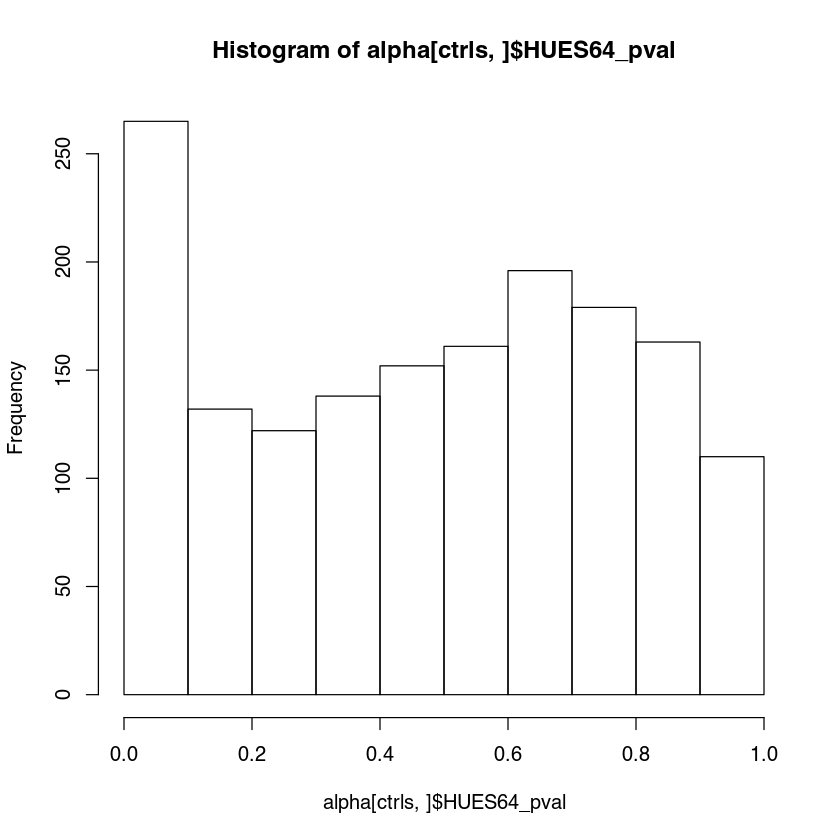

In [35]:
# histogram for negative controls
hist(alpha[ctrls,]$HUES64_pval)

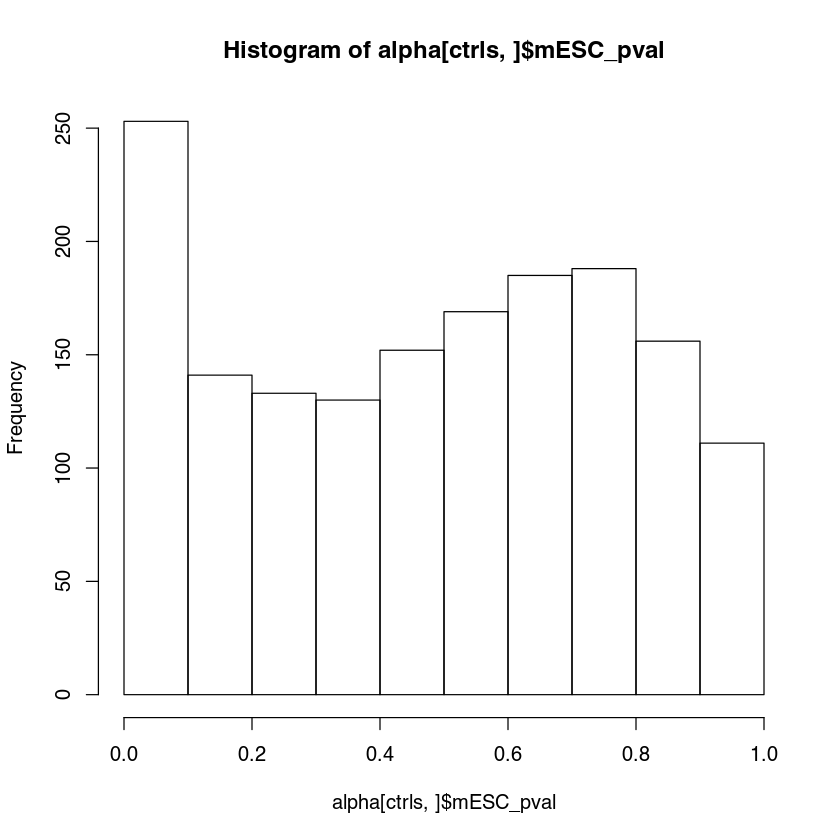

In [36]:
# histogram for negative controls
hist(alpha[ctrls,]$mESC_pval)

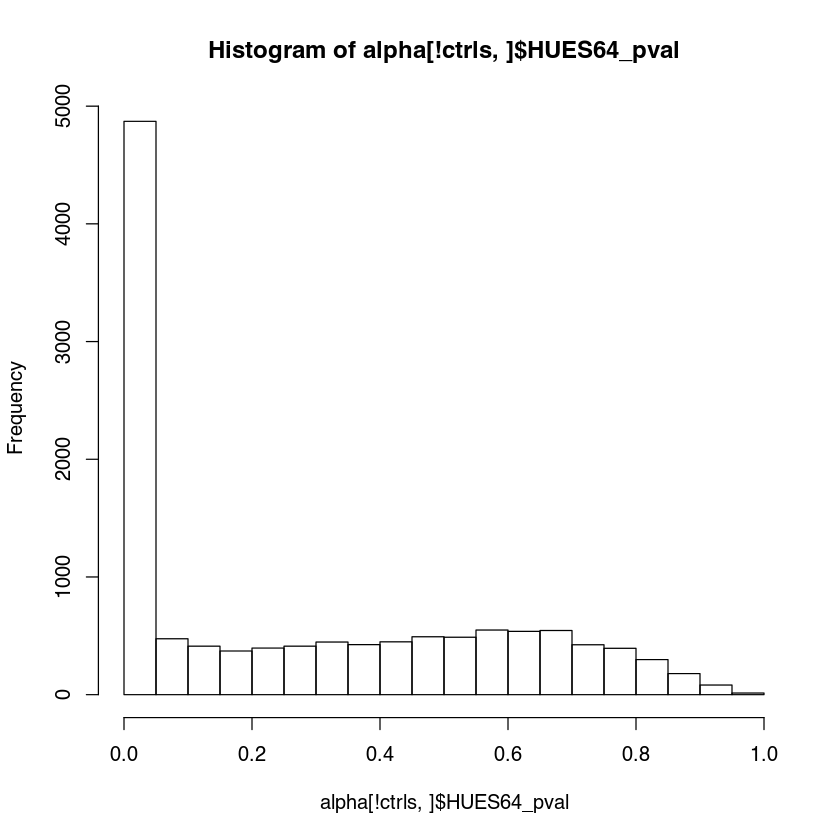

In [37]:
# histogram for TSSs
hist(alpha[!ctrls,]$HUES64_pval)

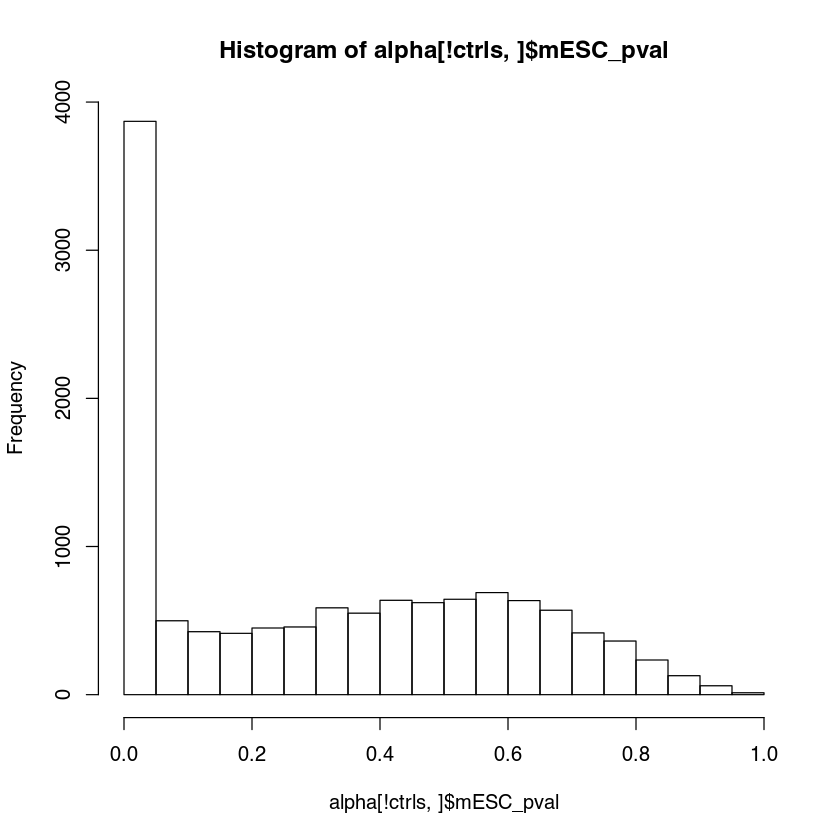

In [38]:
# histogram for TSSs
hist(alpha[!ctrls,]$mESC_pval)

In [39]:
# correct for multiple testing
alpha$HUES64_padj <- p.adjust(alpha$HUES64_pval, method = "fdr")
alpha$mESC_padj <- p.adjust(alpha$mESC_pval, method = "fdr")
head(alpha)

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCCGGAAGTCCCTCCGCGGTGACGAGCACGGCGGAAGTGGGTTCAATGCAGCTCCCCGAAGAACTGTCTCACTCCCGCTCGCCTGACTTCTGGATGGGAGG,7.2952385,6.3159106,2.825214e-75,1.383066e-42,4.596852e-74,1.878236e-41
AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAGGGGAAGTTTCAAAGGGTGTGCCGGGGACCGGGGAAGAGTCTCATTCTCATGAGTCAGCGGATCCGGCCCAGTGTGACTTCACTGCTTCCCCAGAAGAG,1.3267957,1.3488240,1.451021e-01,2.326515e-01,3.319934e-01,5.455262e-01
AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAAACTTTCAAATGTGCTAGGGTTCCTGGAATTTGGAGAGGGAACCGAAAGGGTTTTATGGTTCTTGGGAGACAGCAGAGCACAAAGAGCCAGGGGGTGGA,0.9771642,1.5489158,4.814953e-01,1.057092e-01,7.164347e-01,3.127558e-01
AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACTGGAAAATTCATCCCTGCAACCTTCCCTCCCATTTCACTGGTCAGAGTAAAAATTGGAAGTAGGAAAATTAGTACCACCACATCCTTTGAGTCAGAGAC,0.9761269,0.8181706,4.826910e-01,7.414048e-01,7.167637e-01,8.145300e-01
AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCAGATTCTGATGGGACGATGTCTCAGTAGCACCGCCAATGTGTGTGTAATTGACTGATCCAGTCAGTAGGGGGCCTGACTCCACAACGTTCAAGAGAATC,1.3239991,1.4571282,1.469545e-01,1.559242e-01,3.356231e-01,4.172106e-01
AAAAAAAAATGAGAAGTGTTTAAGACAGCGCAACATTACAATAGAATATTGCCTTGTTTTCTTTCTGGTTCTTCTGTCTCACAGAAATTTCTGTAAGTTCACTCCCTCAGAGGGGAAAAGGCAAGGACACAAGCAAGAGAATGA,1.1364331,1.0491923,3.060530e-01,5.190788e-01,5.653348e-01,7.528672e-01


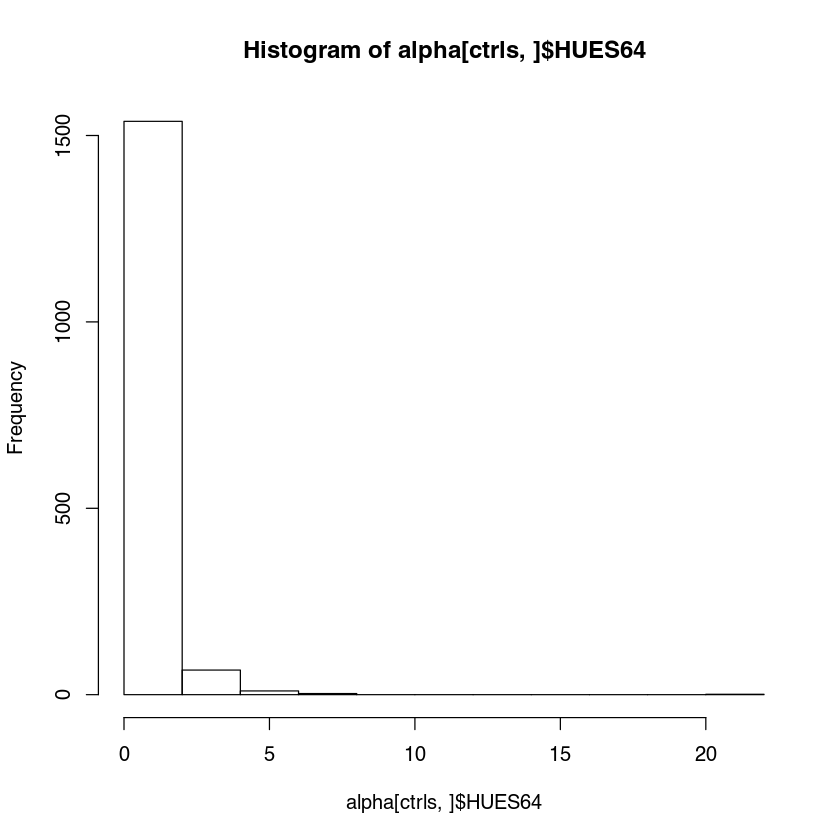

In [40]:
hist(alpha[ctrls,]$HUES64)

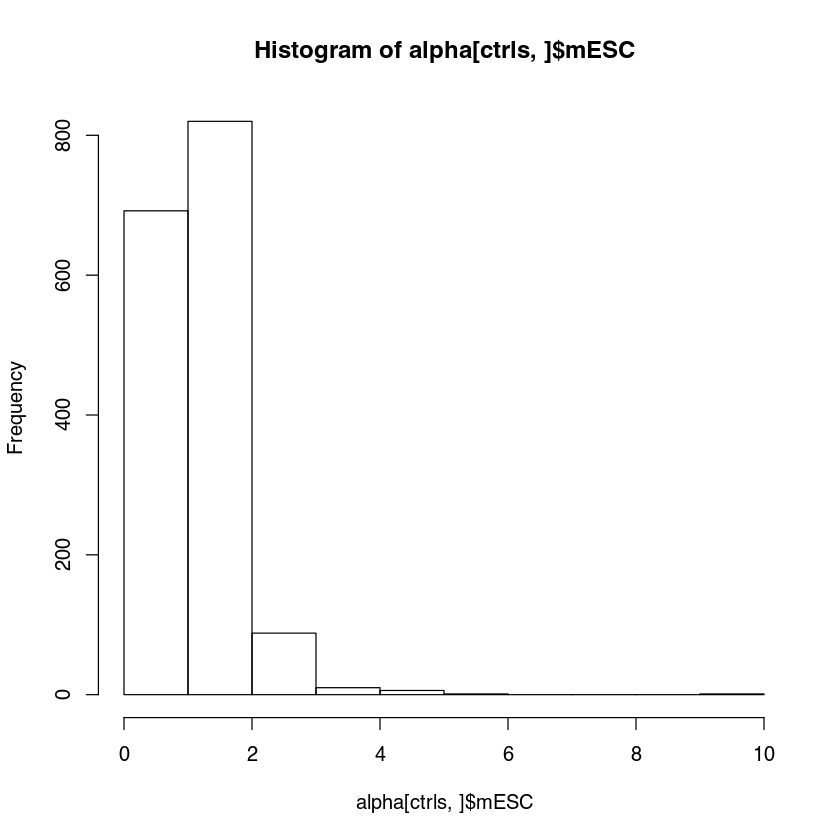

In [41]:
hist(alpha[ctrls,]$mESC)

## 5. write alphas to file

In [42]:
write.table(alpha, file = "../../../data/02__mpra/02__activs/alpha_per_elem.quantification.txt", sep = "\t",
            quote = FALSE)